In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Gradient Threshold

- in the introduction module, you used Canny edge detection to find pixels that were likely to be part of a line in an image
- Canny is great at finding all possible lines in an image, but for lane detection, this gave us a lot of edges on scenery, and cars, and other objects that we ended up discarding
- realistically, with lane finding, we know ahead of time that the lines we are looking for are close to vertical
- so, how can we take advantage of that fact?
    - well, we can use gradients in a smarter way to detect steep edges that are more likely to be lanes in the first place
- with Canny, we were actually taking a derivative with respect to *X* and *Y* in the process of finding edges
    - but let's stop and have a look at what those individual derivatives look like for an image of the road

# Sobel Operator

- the Sobel operator is at the heart of the Canny edge detection algorithm you used in the Introductory Lesson
- applying the Sobel operator to an image is a way of taking the derivative of the image in the *x* or *y* direction


- the operators for $Sobel_x$ and $Sobel_y$ respectively, look like this: $S_x =  \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}$ &nbsp;&nbsp;&nbsp; $S_y =  \begin{pmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{pmatrix}$


- these are examples of Sobel operators with a kernel size of 3 (implying a 3 x 3 operator in each case)
- this is the minimum size, but the kernel size can be any odd number
- a larger kernel implies taking the gradient over a larger region of the image, or, in other words, a smoother gradient

- to understand how these operators take the derivative, you can think of overlaying either one on a 3 x 3 region of an image
- if the image is flat across that region (i.e., there is little change in values across the given region), then the result (summing the element-wise product of the operator and corresponding image pixels) will be zero
    - $gradient = \sum(region*S_x)$
    
    
- for example, given: $region = \begin{pmatrix} 2 & 2 & 2 \\ 2 & 2 & 2 \\ 2 & 2 & 2 \end{pmatrix}$ &nbsp;,&nbsp;&nbsp; $S_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}$ &nbsp;&nbsp; the element-wise product would be: $\begin{pmatrix} -2 & 0 & 2 \\ -4 & 0 & 4 \\ -2 & 0 & 2 \end{pmatrix}$


- in which case, the sum of this matrix is 0, implying a flat gradient (in the x-direction in this calculation, although the y-direction is also zero in this example)

- if, instead, for example, you apply the *$S_x$* operator to a region of the image where values are rising from left to right, then the result will be positive, implying a positive derivative


- given: $region = \begin{pmatrix} 1 & 2 & 3 \\ 1 & 2 & 3 \\ 1 & 2 & 3 \end{pmatrix}$ &nbsp;,&nbsp;&nbsp; $S_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}$ &nbsp;&nbsp; the element-wise product would be: $\begin{pmatrix} -1 & 0 & 3 \\ -2 & 0 & 6 \\ -1 & 0 & 3 \end{pmatrix}$


- this time, the sum of this matrix is 8, meaning a gradient exists in the x-direction
    - note that in this example image region, if you applied the $S_y$ operator, the result would be a gradient of 0 in the y-direction, as the values are not varying from top to bottom

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("resources/sobel_example.jpg")

<IPython.core.display.Javascript object>

In [3]:
# You need to pass a single color channel to the cv2.Sobel() function
# So first convert it to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Calculate the derivative in the x direction (the 1, 0 at the end denotes x direction)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
# Calculate the derivative in the y direction (the 0, 1 at the end denotes y direction)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

<IPython.core.display.Javascript object>

**Note:** Make sure you use the correct grayscale conversion depending on how you've read in your images. Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

In [4]:
# Calculate the absolute value of the x derivative
abs_sobelx = np.absolute(sobelx)
# Calculate the absolute value of the y derivative
abs_sobely = np.absolute(sobely)

# Convert the absolute value image to 8-bit
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

<IPython.core.display.Javascript object>

**Note:** It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, it can be useful in the event that you've written a function to apply a particular threshold, and you want it to work the same on input images of different scales, like jpg vs. png. You could just as well choose a different standard range of values, like 0 to 1 etc.

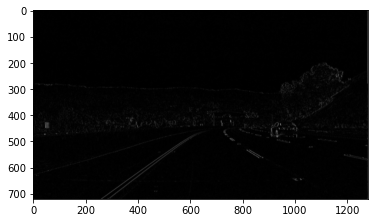

<IPython.core.display.Javascript object>

In [5]:
plt.imshow(abs_sobelx, "gray")

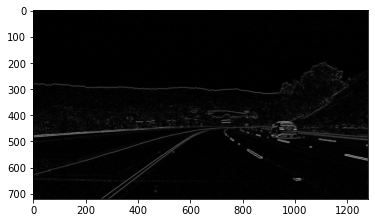

<IPython.core.display.Javascript object>

In [6]:
plt.imshow(abs_sobely, "gray")

- in the above images, you can see that the gradients taken in both the *x* and the *y* directions detect the lane lines and pick up other edges
  - taking the gradient in the *x* direction emphasizes edges closer to vertical
  - alternatively, taking the gradient in the *y* direction emphasizes edges closer to horizontal

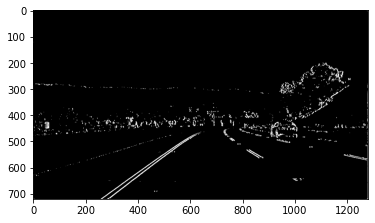

<IPython.core.display.Javascript object>

In [7]:
# Create a binary threshold to select pixels based on gradient strength
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap="gray")

- pixels have a value of 1 or 0 based on the strength of the *x* gradient

# Applying Sobel

In [8]:
# Read in an image and grayscale it
image = mpimg.imread("resources/signs_vehicles_xygrad.png")

# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold
def abs_sobel_thresh(img, orient="x", thresh_min=0, thresh_max=255):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == "x":
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == "y":
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

<IPython.core.display.Javascript object>

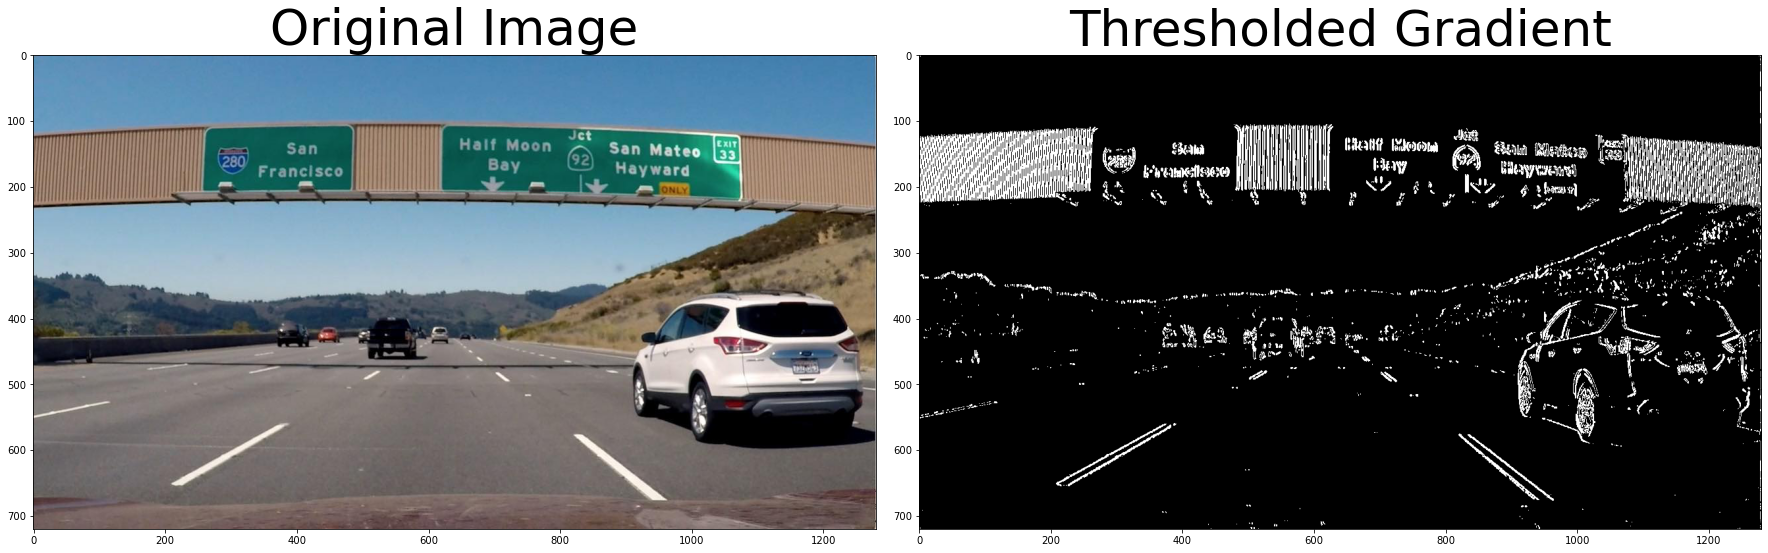

<IPython.core.display.Javascript object>

In [9]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient="x", thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(grad_binary, cmap="gray")
ax2.set_title("Thresholded Gradient", fontsize=50)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

- with the result of the last quiz, you can now take the gradient in *x* or *y* and set thresholds to identify pixels within a certain gradient range
- if you play around with the thresholds a bit, you'll find the *x-gradient* does a cleaner job of picking up the lane lines, but you can see the lines in the *y-gradient* as well

# Magnitude of the Gradient

- the magnitude, or absolute value, of the gradient is just the square root of the squares of the individual *x* and *y* gradients
- for a gradient in both the *x* and *y* directions, the magnitude is the square root of the sum of the squares
  - $abs\_sobelx=\sqrt{(sobel_x)^2}$
  - $abs\_sobely=\sqrt{(sobel_y)^2}$
  - $abs\_sobelxy=\sqrt{(sobel_x)^2 + (sobel_y)^2}$

- it's also worth considering the size of the region in the image over which you'll be taking the gradient
- you can modify the kernel size for the Sobel operator to change the size of this region
- taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales
- the default Sobel kernel size is 3, but here you'll define a new function that takes kernel size as a parameter

- it's important to note here that the kernel size should be an odd number
- since we are searching for the gradient around a given pixel, we want to have an equal number of pixels in each direction of the region from this central pixel, leading to an odd-numbered filter size
    - a filter of size three has the central pixel with one additional pixel in each direction
    - a filter of size five has an additional two pixels outward from the central pixel in each direction

In [10]:
# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

<IPython.core.display.Javascript object>

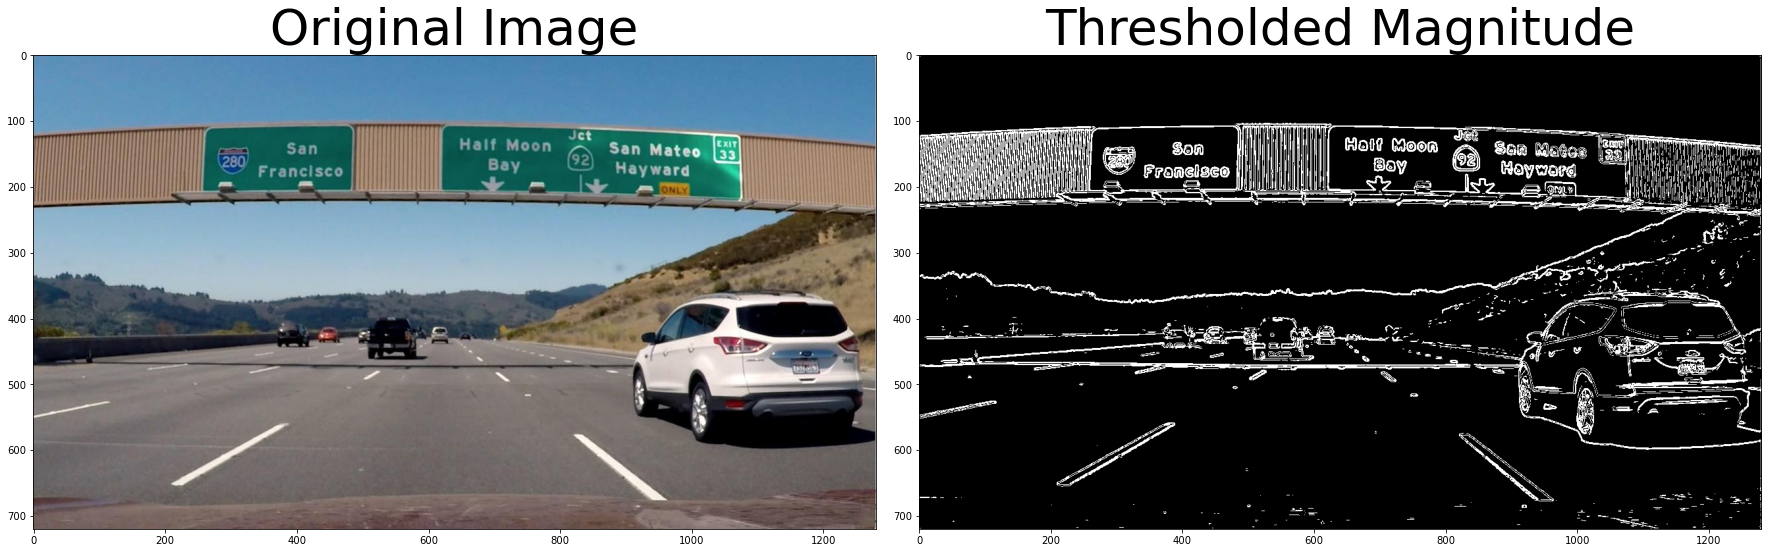

<IPython.core.display.Javascript object>

In [11]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(mag_binary, cmap="gray")
ax2.set_title("Thresholded Magnitude", fontsize=50)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

- when you play around with the thresholding for the gradient magnitude, you find what you might expect, namely, that it picks up the lane lines well, but with a lot of other stuff detected too
- gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges
- in the case of lane lines, we're interested only in edges of a particular orientation

# Direction of the Gradient

- the direction of the gradient is simply the inverse tangent (arctangent) of the *y* gradient divided by the *x* gradient
  - $arctan=\left(\dfrac{sobel_y}{sobel_x}\right)$

- each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of $−\frac{\pi}{2}$ to $\frac{\pi}{2}$
- an orientation of *0* implies a vertical line and orientations of $+/− \frac{\pi}{2}$ imply horizontal lines

**Note** that in the quiz below, we actually utilize `np.arctan2`, which can return values between $+/− \pi$; however, as we'll take the absolute value of $sobel_x$, this restricts the values to $+/− \frac{\pi}{2}$ as shown here https://en.wikipedia.org/wiki/Atan2

In [12]:
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient and applies a threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    # 5) Create a binary mask where direction thresholds are met
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

<IPython.core.display.Javascript object>

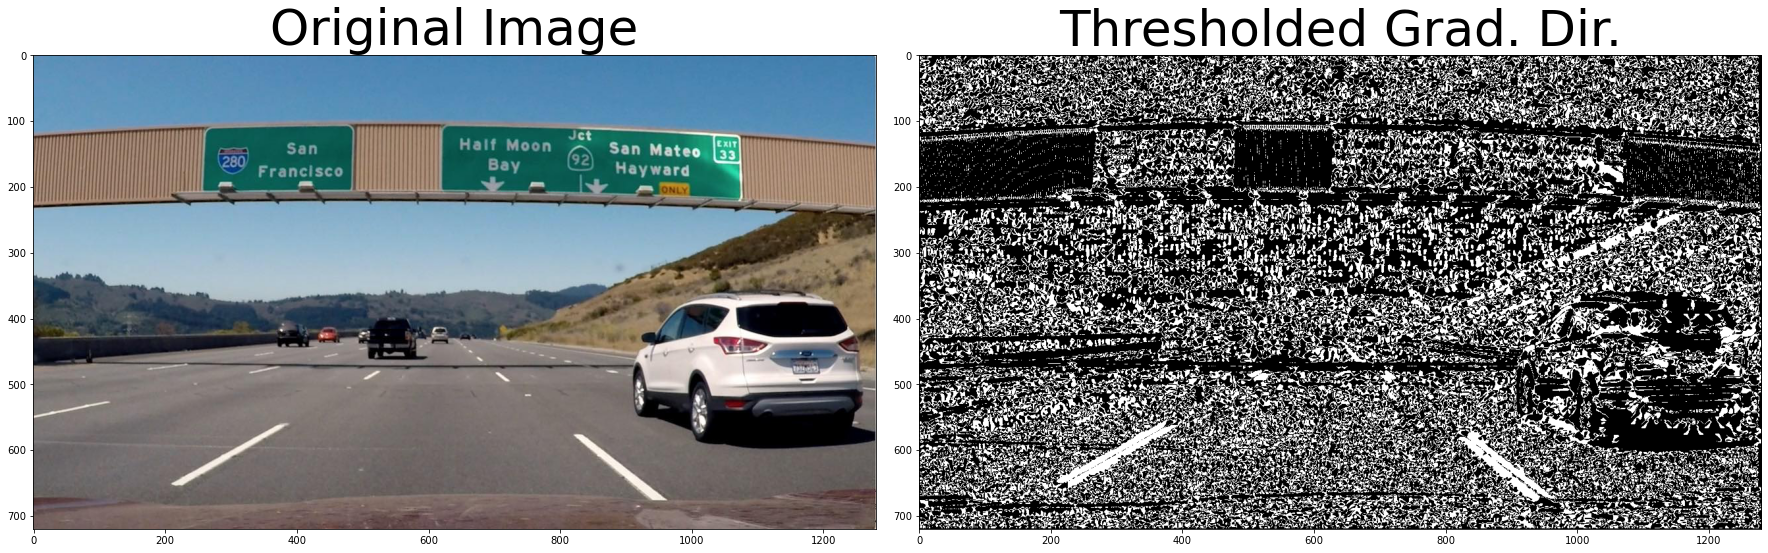

<IPython.core.display.Javascript object>

In [13]:
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(dir_binary, cmap="gray")
ax2.set_title("Thresholded Grad. Dir.", fontsize=50)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

# Combining Thresholds

In [14]:
# abs_sobel_thresh with different arguments
def abs_sobel_thresh(img, orient="x", sobel_kernel=3, thresh=(0, 255)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == "x":
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == "y":
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

<IPython.core.display.Javascript object>

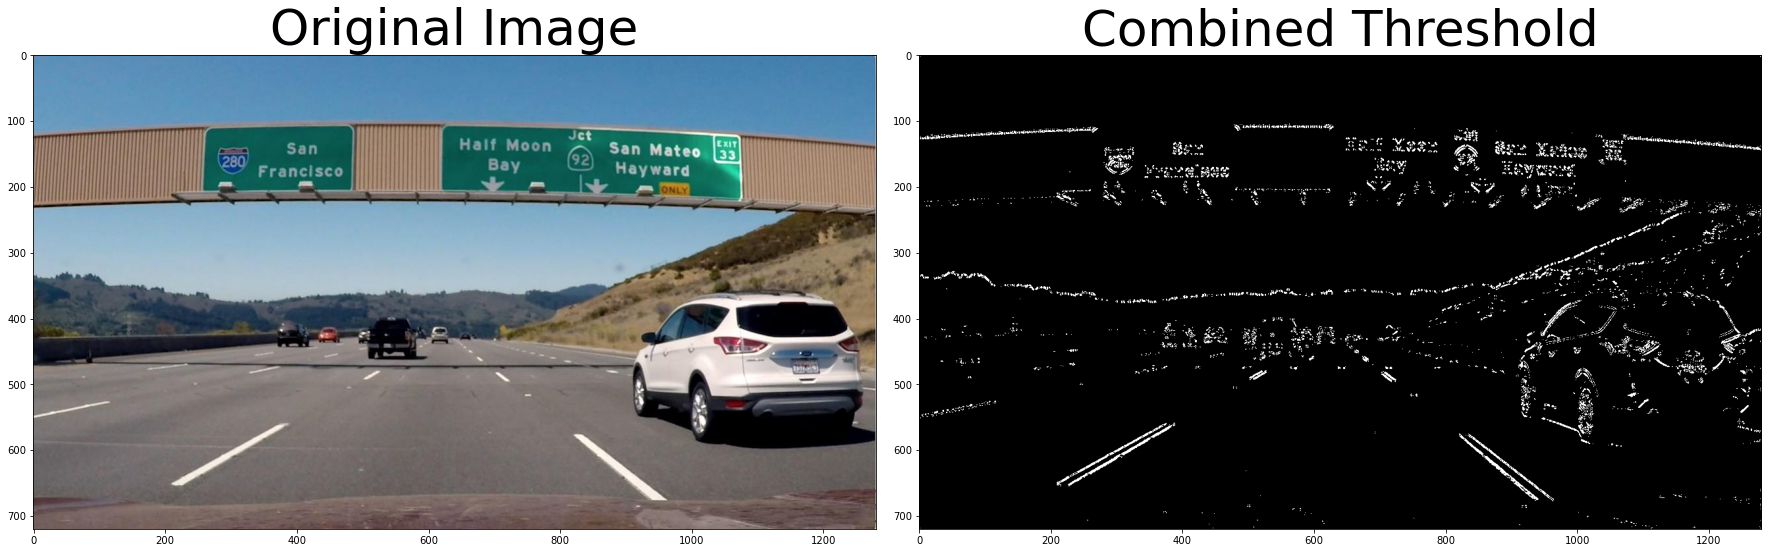

<IPython.core.display.Javascript object>

In [15]:
# Choose a Sobel kernel size
ksize = 3  # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient="x", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient="y", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(combined, cmap="gray")
ax2.set_title("Combined Threshold", fontsize=50)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

# Color Spaces and Thresholding

- in the introductory lesson, we converted our road images to grayscale, before detecting edges
- but in making this conversion, we lose valuable color information
    - for example, when we convert to grayscale, the yellow line almost disappears
- color spaces, give us more information about an image than grayscale alone

- the road images we've seen, they're all composed of red, green, and blue values or RGB
    - and in the past, we've used some combination of masking and color thresholds on these RGB values to pick out bright white lane pixels
    - this lane detection can work well alongside gradient detection which relies on grayscale intensity measurements
- however, RGB thresholding doesn't work that well in images that include varying light conditions or when lanes are a different color like yellow
    - we can break images of a road into it's separate RGB components which are often called channels
    - the brighter pixels indicate higher values of red, green, or blue, respectively
    - looking at the lane lines, we can see that the red and green channels are high for both the white and yellow lane lines
    - but if we look at the blue channel, there's almost no blue component in the yellow lane
    - so the **R and G channels** will be the most useful for isolating both **white and yellow** lane pixels
    - but we can also see that the red and green values change under different levels of brightness at the back of the image
        - they get lower under shadow and don't consistently recognize the lane under extreme brightness

- there are many other ways to represent the colors in an image besides just composed of red, green and blue values
    - these different color representations are often called color spaces
- a color space is a specific organization of colors
- color spaces provide a way to categorize colors and represent them in digital images

- RGB is red, green, blue color space
- you can think of this as a 3D space where any color can be represented by a 3D coordinate of R, G, and B values
<img src="resources/rgb_color_space.png" style="width: 40%;"/>

**Note:** If you read in an image using `matplotlib.image.imread()` you will get an RGB image, but if you read it in using OpenCV `cv2.imread()` this will give you a BGR image.

- there's also **HSV** color space, for **hue, saturation, and value**
- and there's **HLS**, for **hue, lightness, and saturation**
- these are some of the most commonly used color spaces in image analysis
<img src="resources/hsv_hls_color_spaces.png" style="width: 80%;"/>

- for both of these, **H** has a range from **0 to 179** for degrees around the cylindrical color space
- working in HLS color space isolates the lightness or L component of each pixel in an image
    - this is the component that varies the most under different lighting conditions
- but the H and S channels stay fairly consistent under shadow or excessive brightness
    - if we use these channels only and discard the information in the L channel, we should be able to detect different colors of lane lines more reliably than in RGB color space

- to get some intuition about these color spaces, we can generally think of **Hue as the value that represents color independent of any change in brightness**
- so if we imagine a basic red paint color, then add some white to it or some black to make that color lighter or darker -- the underlying color remains the same and the hue for all of these colors will be the same

- on the other hand, Lightness and Value represent different ways to measure the relative lightness or darkness of a color
- for example, a dark red will have a similar hue but much lower value for lightness than a light red
- saturation also plays a part in this
    - **saturation is a measurement of colorfulnes**
    - so, as colors get lighter and closer to white, they have a lower saturation value
    - colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value

- most of these different color spaces were either inspired by the human vision system, and/or developed for efficient use in television screen displays and computer graphics
- more about the history and the derivation of HLS and HSV color spaces here https://en.wikipedia.org/wiki/HSL_and_HSV

- OpenCV provides a function `hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)` that converts images from one color space to another
- the math behind this conversion, take a look at the equations below
- note that all this math is for converting 8-bit images, which is the format for most road images in this course
- these equations convert one color at a time from RGB to HLS

**Constants**
- $V_{max} \leftarrow max(R,G,B)$
- $V_{min} \leftarrow min(R,G,B)$


- these are the maximum and minimum values across all three RGB values for a given color (by pixel)
- note that in these equations, it would be necessary to divide the RGB values by 255 such that they fall in the range (0,1)(0, 1)(0,1), but OpenCV will perform this in `cv2.cvtColor()`
- L and S are scaled back up after the transformations take place, while H is halved for use in 8-bit images

**H channel conversion equations**
- there are three different equations, which one is used depends on the the value of $V_{max}$ whether that's R, G, or B
  - $H \leftarrow \dfrac{30(G-B)}{V_{max}-V_{min}}$, if $V_{max}=R$
  - $H \leftarrow 60 + \dfrac{30(B-R)}{V_{max}-V_{min}}$, if $V_{max}=G$
  - $H \leftarrow 120 + \dfrac{30(R-G)}{V_{max}-V_{min}}$, if $V_{max}=B$

**Note:** In OpenCV, for 8-bit images, the range of H is from 0-179. It's typically from 0-359 for degrees around the cylindrical colorspace, but this number is divided in half so that the range can be represented in an 8-bit image whose color values range from 0-255.

**L channel conversion equation**
  - $L \leftarrow \dfrac{V_{max}+V_{min}}{2}$

**S channel conversion equations**
  - $S \leftarrow \dfrac{V_{max}-V_{min}}{V_{max}+V_{min}}$, if $L<0.5$
  - $S \leftarrow \dfrac{V_{max}-V_{min}}{2-(V_{max}+V_{min})}$, if $L\geq0.5$

# HLS and Color Thresholds

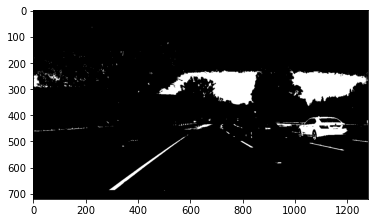

<IPython.core.display.Javascript object>

In [16]:
image = mpimg.imread("resources/colorspace_test_images/test6.jpg")
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(binary, "gray")  # gray binary

- we might have also explored thresholding individual RGB color channels
- we can take a look at them side by side to see which ones do a better job of picking up the lane lines

In [17]:
R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

<IPython.core.display.Javascript object>

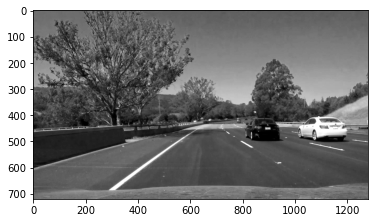

<IPython.core.display.Javascript object>

In [18]:
plt.imshow(R, "gray")

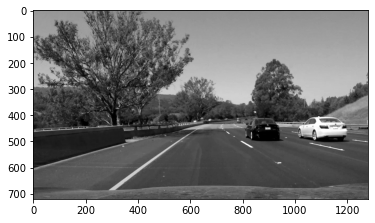

<IPython.core.display.Javascript object>

In [19]:
plt.imshow(G, "gray")

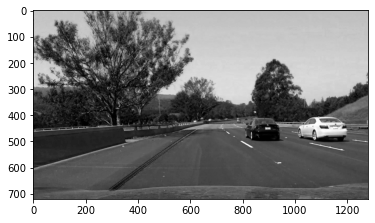

<IPython.core.display.Javascript object>

In [20]:
plt.imshow(B, "gray")

- the R channel does a reasonable job of highlighting the lines, and we can apply a similar threshold to find lane-line pixels

In [21]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

<IPython.core.display.Javascript object>

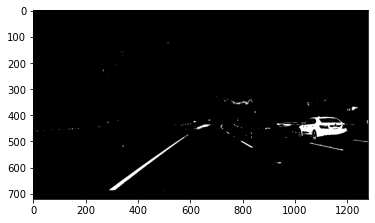

<IPython.core.display.Javascript object>

In [22]:
plt.imshow(binary, "gray")  # R binary

- in this lesson, we're looking at different color spaces
- while there are several that are worth exploring, here we'll look specifically at HLS
- when we separate the H, L, and S channels we get the following result

In [23]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:, :, 0]
L = hls[:, :, 1]
S = hls[:, :, 2]

<IPython.core.display.Javascript object>

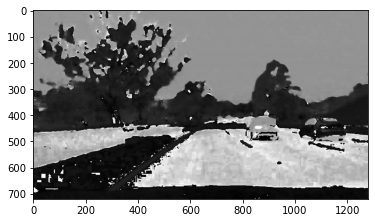

<IPython.core.display.Javascript object>

In [24]:
plt.imshow(H, "gray")

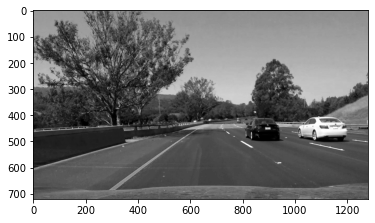

<IPython.core.display.Javascript object>

In [25]:
plt.imshow(L, "gray")

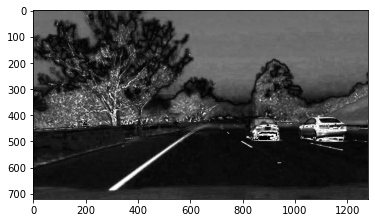

<IPython.core.display.Javascript object>

In [26]:
plt.imshow(S, "gray")

- the S channel picks up the lines well, so let's try applying a threshold there

In [27]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

<IPython.core.display.Javascript object>

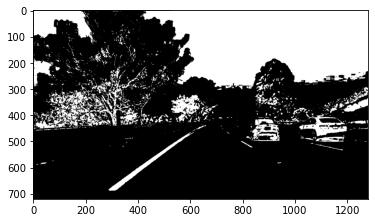

<IPython.core.display.Javascript object>

In [28]:
plt.imshow(binary, "gray")

- we can also see that in the H channel, the lane lines appear dark, so we could try a low threshold there and obtain the following result

In [29]:
thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

<IPython.core.display.Javascript object>

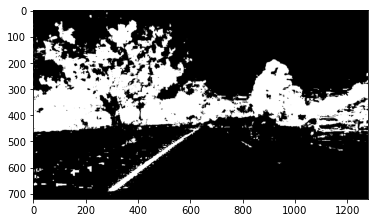

<IPython.core.display.Javascript object>

In [30]:
plt.imshow(binary, "gray")  # H binary

- from these examples, we can see that the S channel is probably our best bet
- it's cleaner than the H channel result and a bit better than the R channel or simple grayscaling
- but it's not clear that one method is far superior to the others.


- in each case, we've tweaked the threshold parameters to do as good a job as possible of picking out the lines
- where we can really see a difference in results, however, is when we step to a new frame, where there are shadows and different colors in the pavement

- now you can see that, the S channel is still doing a fairly robust job of picking up the lines under very different color and contrast conditions, while the other selections look messy
- we could tweak the thresholds and get closer in the other channels, but the **S channel is preferable because it is more robust to changing conditions**

- it's worth noting, however, that the **R channel still does rather well on the white lines, perhaps even better than the S channel**
- as with gradients, it's worth considering how we might combine various color thresholds to make the most robust identification of the lines

## HLS Quiz

In [31]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    # 3) Return a binary image of threshold result
    return binary_output

<IPython.core.display.Javascript object>

In [32]:
# Tune the threshold to try to match the above image!
hls_binary = hls_select(image, thresh=(90, 255))

<IPython.core.display.Javascript object>

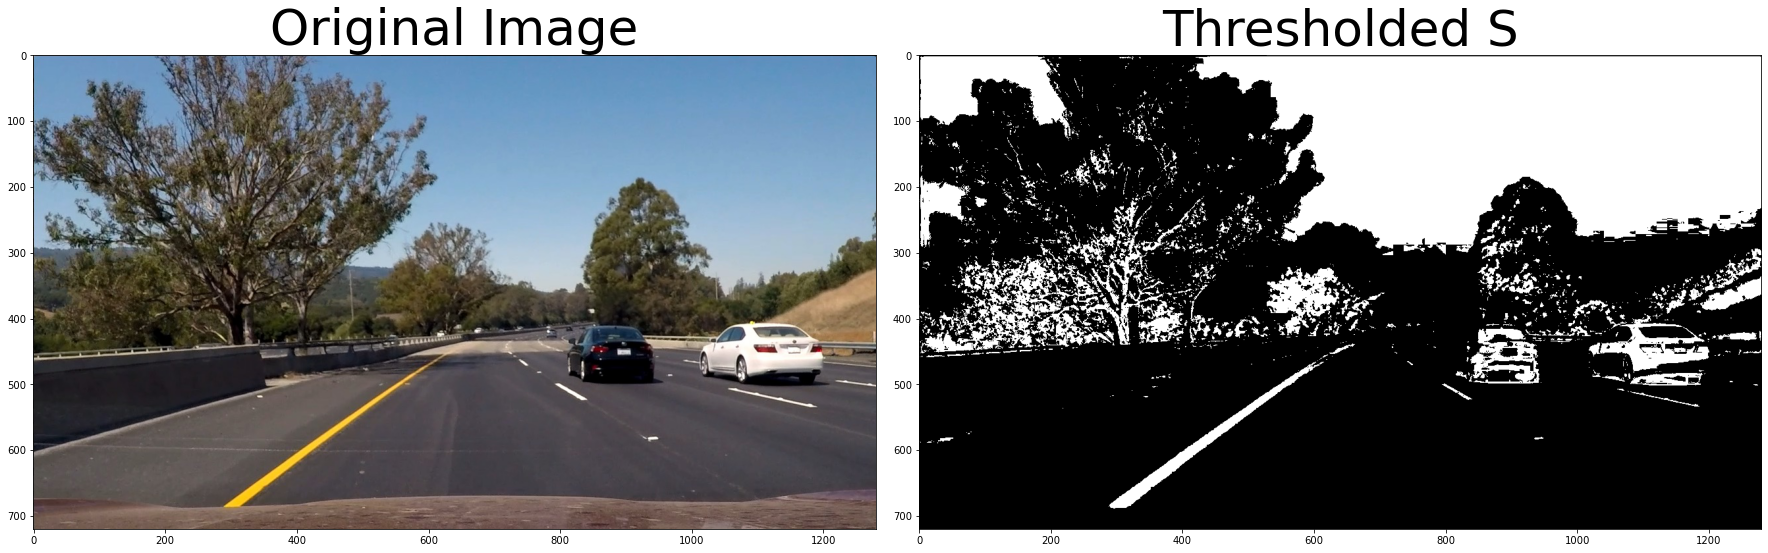

<IPython.core.display.Javascript object>

In [33]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(hls_binary, cmap="gray")
ax2.set_title("Thresholded S", fontsize=50)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

# Color and Gradient

- at this point, it's okay to detect edges around trees or cars because these lines can be mostly filtered out by applying a mask to the image and essentially cropping out the area outside of the lane lines
- it's most important that we reliably detect different colors of lane lines under varying degrees of daylight and shadow
- we can clearly see which parts of the lane lines were detected by the gradient threshold and which parts were detected by the color threshold by stacking the channels and seeing the individual components
- we can create a binary combination of these two images to map out where either the color or gradient thresholds were met

In [34]:
image = mpimg.imread("resources/bridge_shadow.jpg")

<IPython.core.display.Javascript object>

In [35]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:, :, 2]

<IPython.core.display.Javascript object>

In [36]:
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

<IPython.core.display.Javascript object>

In [37]:
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
abs_sobelx = np.absolute(
    sobelx
)  # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

<IPython.core.display.Javascript object>

In [38]:
# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

<IPython.core.display.Javascript object>

In [39]:
# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

<IPython.core.display.Javascript object>

In [40]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

<IPython.core.display.Javascript object>

In [41]:
# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

<IPython.core.display.Javascript object>

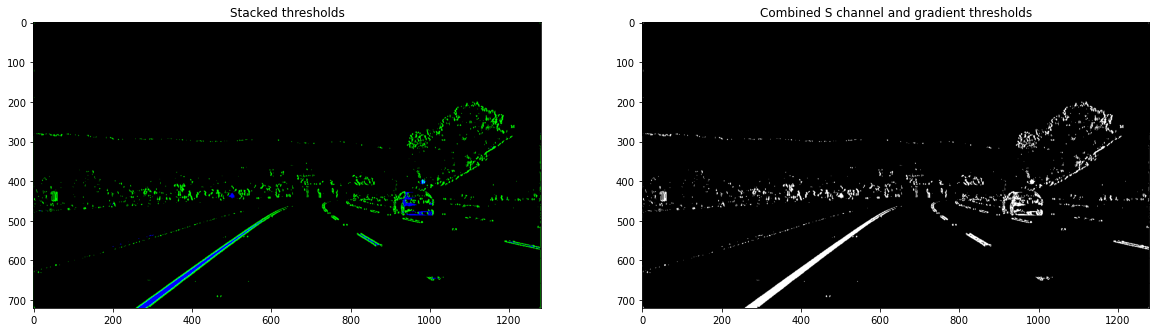

<IPython.core.display.Javascript object>

In [42]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)
ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")

(Left) Stacked image; the green is the gradient threshold component and the blue is the color channel threshold component.

(Right) black and white combined thresholded image - this one has combined both gradient and color thresholds into one image.

In [43]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(
        sobelx
    )  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

<IPython.core.display.Javascript object>

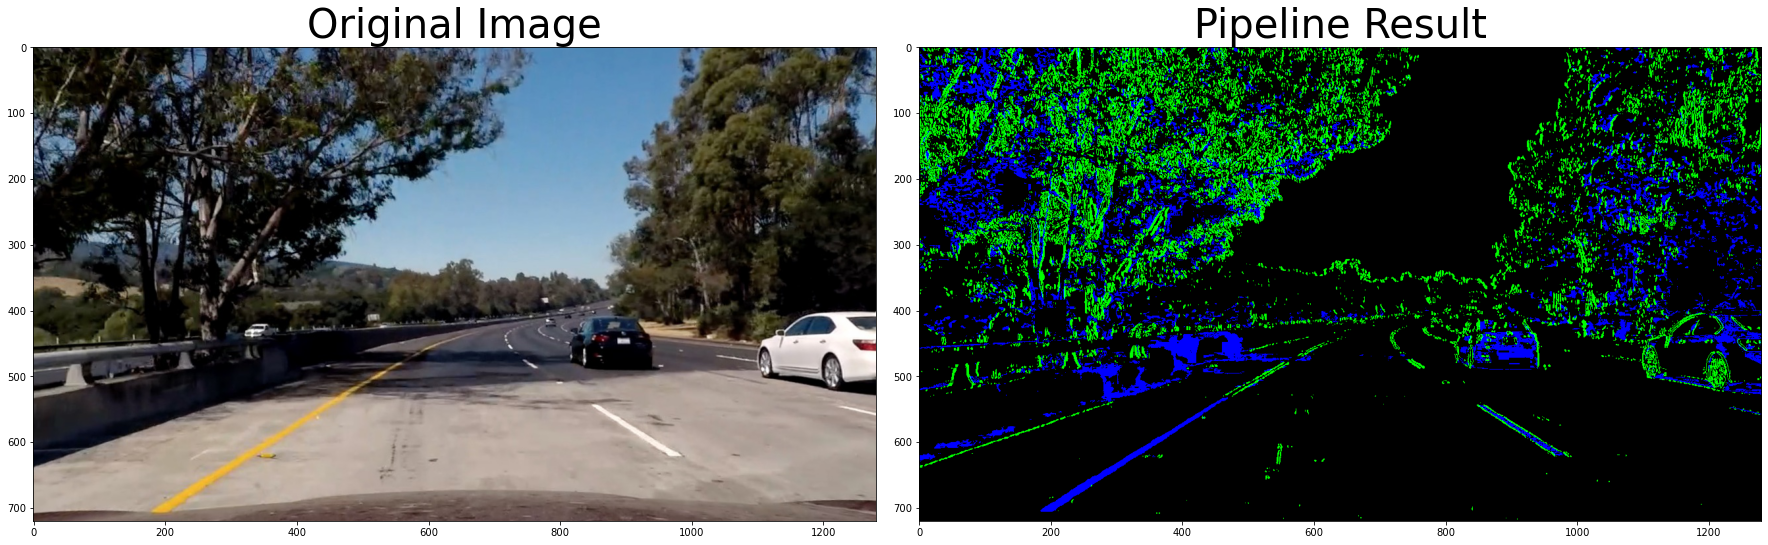

<IPython.core.display.Javascript object>

In [44]:
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title("Original Image", fontsize=40)

ax2.imshow(result)
ax2.set_title("Pipeline Result", fontsize=40)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)